# 作业：手写数字加法机

本文件是与集智AI学园出品的系列课程“火炬上的深度学习”配套的作业notebook。本作业要求学员构造一个卷积神经网，输入两张手写数字图片，输出这两个数字的和。

本文件提供了一个完成做的大框架，学员需要自行修改、添加代码，从而完成任务

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码


In [200]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [201]:

# 定义需要用到的超参数
image_size = 28  #图像的总尺寸28*28
num_classes = 10  #标签的种类数
num_epochs = 20  #训练的总循环周期
batch_size = 64

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中

train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 由于每一个样本需要输入两个图片，因此每一个loader和sampler都有两个

sampler1 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))
sampler2 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))

# 训练数据的两个加载器
train_loader1 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = sampler1
                                           )
train_loader2 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = sampler2
                                           )

# 校验数据和测试数据都各自有两套
val_size = 5000
val_indices1 = range(val_size)
val_indices2 = np.random.permutation(range(val_size))
test_indices1 = range(val_size, len(test_dataset))
test_indices2 = np.random.permutation(test_indices1)
val_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(val_indices1)
val_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(val_indices2)

test_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(test_indices1)
test_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(test_indices2)

val_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler1
                                        )
val_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler2
                                        )
test_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler1
                                         )
test_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler2
                                         )

# MINST Adder

为了实现加法器，需要同时处理两个手写体数字图像，并对它进行相应的图像处理
因此，网络的架构为两个卷积神经网络，串联上两个全链接层

In [202]:

class MINSTAdder(nn.Module):
    def __init__(self):
        super(MINSTAdder, self).__init__()
        #处理第一个图像处理用的卷积网络部件
        self.net1_conv1 = nn.Conv2d(1, 20, 5, padding = 2)
        self.net_pool = nn.MaxPool2d(2, 2)
        self.net1_conv2 = nn.Conv2d(20, 40, 5, padding = 0)
        self.net1_conv3 = nn.Conv2d(40, 80, 3, padding = 0)#加第三层卷积层，明显有助于Loss的下降和精度的提高。
        
        
        self.bn1d = nn.BatchNorm1d(1000)
        
        
        #处理第二个图像处理用的卷积网络部件
        self.net2_conv1 = nn.Conv2d(1, 20, 5, padding = 2)
        self.net_pool = nn.MaxPool2d(2, 2)
        self.net2_conv2 = nn.Conv2d(20, 40, 5, padding = 0)
        self.net2_conv3 = nn.Conv2d(40, 80, 3, padding = 0)
        self.bn1d = nn.BatchNorm1d(1000)
        
        
        
        #后面的全连阶层
        self.fc1 = nn.Linear(2 * 3 * 3 * 80 , 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1)
    def forward(self, x, y, training = True):
        #第一张图像的处理流程
        x = F.leaky_relu(self.net1_conv1(x))
        x = self.net_pool(x)
        x = F.leaky_relu(self.net1_conv2(x))
        x = self.net_pool(x)
        x = F.leaky_relu(self.net1_conv3(x))
       
        
        x = x.view(-1, 3 * 3 * 80)
        
        #第二张图像的处理流程
        y = F.leaky_relu(self.net2_conv1(y))
        y = self.net_pool(y)
        y = F.leaky_relu(self.net2_conv2(y))
        y = self.net_pool(y)
        y = F.leaky_relu(self.net2_conv3(y))
        
        y = y.view(-1, 3 * 3 * 80)
        
        #将前两部处理得到的张量并列到一起，喂给两层全链接前馈网络，最后输出预测数值
        z = torch.cat((x, y), 1)
        z = self.fc1(z)
        z = self.bn1d(z) #批量正则化，没有正则化loss有问题
        z = F.leaky_relu(z)
        z = F.dropout(z, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        z = self.fc2(z)
        z = F.leaky_relu(z)
        z = self.fc3(z)
        z = F.leaky_relu(z)
        
        return z

# 计算准确度的函数（有多少数字给出了严格的正确输出结果）
def rightness(y, target):
    out = torch.round(y).type(torch.LongTensor)
    out = out.eq(target).sum()
    out1 = y.size()[0]
    return(out, out1)

In [203]:
# 将网络定义为一个预测器，来对加法的结果进行预测，因此用MSE平均平方误差作为我们的损失函数
net = MINSTAdder()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(),lr=0.01,momentum = 0.9)#lr=0.0001 loss不下降，lr=0.1太大，loss会变成nan
results = {}

In [204]:
# 开始训练循环，本部分代码需要补齐
num_epochs = 20
records = []
for epoch in range(num_epochs):
    losses = []
    # 一个关键技术难点是对两个数据加载器进行读取成对儿的数据。我们的办法是通过zip命令，将loader1和2并列在一起，一对一对的读取数据
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        ((x1, y1), (x2, y2)) = data
        optimizer.zero_grad()
        net.train()
        outputs = net(Variable(x1), Variable(x2))
        labels = y1 + y2
        loss = criterion(outputs.type(torch.FloatTensor), Variable(labels.type(torch.FloatTensor)))
        loss.backward()
        optimizer.step()
        losses.append(loss.data.numpy())#不加data.numpy，训练时内存会不足
        
        
        if idx % 100 == 0:
            net.eval()
            val_losses=[]
            val_rights = [] #记录校验数据集准确率的容器
            
            for jdx, val_data in enumerate(zip(val_loader1, val_loader2)):
                ((x3, y3),(x4, y4)) = val_data
                val_outputs = net(Variable(x3), Variable(x4))
                val_labels = y3 + y4
                val_loss = criterion(val_outputs.type(torch.FloatTensor), Variable(val_labels.type(torch.FloatTensor)))
                val_losses.append(val_loss.data.numpy())#要加data.numpy，否则.2f无法运行，打印也有问题
                val_rights.append(rightness(val_outputs.data, val_labels))#val_outputs要加data
                right_ratio = float(np.sum([tup1 for tup1,tup2 in val_rights])) / float(np.sum([tup2 for tup1,tup2 in val_rights]))

                

                
            
            #每间隔一定周期就打印一下训练集、校验集的准确率结果
            print('第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f},准确率：{:.2f}'.format(
                epoch, idx, len(train_loader1), np.mean(losses), np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses)])

第0周期，第(0/938)个撮，训练误差：88.12, 校验误差：95.45,准确率：0.01
第0周期，第(100/938)个撮，训练误差：15.33, 校验误差：6.53,准确率：0.14
第0周期，第(200/938)个撮，训练误差：10.04, 校验误差：9.92,准确率：0.09
第0周期，第(300/938)个撮，训练误差：8.03, 校验误差：4.54,准确率：0.18
第0周期，第(400/938)个撮，训练误差：6.91, 校验误差：3.26,准确率：0.28
第0周期，第(500/938)个撮，训练误差：6.15, 校验误差：2.93,准确率：0.30
第0周期，第(600/938)个撮，训练误差：5.57, 校验误差：2.44,准确率：0.32
第0周期，第(700/938)个撮，训练误差：5.16, 校验误差：2.38,准确率：0.31
第0周期，第(800/938)个撮，训练误差：4.81, 校验误差：2.33,准确率：0.35
第0周期，第(900/938)个撮，训练误差：4.52, 校验误差：2.27,准确率：0.33
第1周期，第(0/938)个撮，训练误差：2.79, 校验误差：2.07,准确率：0.34
第1周期，第(100/938)个撮，训练误差：1.95, 校验误差：1.87,准确率：0.38
第1周期，第(200/938)个撮，训练误差：1.90, 校验误差：1.80,准确率：0.40
第1周期，第(300/938)个撮，训练误差：1.86, 校验误差：1.73,准确率：0.38
第1周期，第(400/938)个撮，训练误差：1.79, 校验误差：1.54,准确率：0.46
第1周期，第(500/938)个撮，训练误差：1.74, 校验误差：1.46,准确率：0.46
第1周期，第(600/938)个撮，训练误差：1.70, 校验误差：1.57,准确率：0.42
第1周期，第(700/938)个撮，训练误差：1.64, 校验误差：1.39,准确率：0.47
第1周期，第(800/938)个撮，训练误差：1.61, 校验误差：1.36,准确率：0.46
第1周期，第(900/938)个撮，训练误差：1.58, 校验误差：1.23,准确率：0.49
第2周期，第(0/938)个撮，训练误差：1.02, 校验误差：1.17,准确率

第17周期，第(0/938)个撮，训练误差：0.59, 校验误差：0.47,准确率：0.87
第17周期，第(100/938)个撮，训练误差：0.26, 校验误差：0.46,准确率：0.87
第17周期，第(200/938)个撮，训练误差：0.24, 校验误差：0.41,准确率：0.90
第17周期，第(300/938)个撮，训练误差：0.23, 校验误差：0.37,准确率：0.91
第17周期，第(400/938)个撮，训练误差：0.22, 校验误差：0.40,准确率：0.91
第17周期，第(500/938)个撮，训练误差：0.23, 校验误差：0.43,准确率：0.89
第17周期，第(600/938)个撮，训练误差：0.24, 校验误差：0.37,准确率：0.90
第17周期，第(700/938)个撮，训练误差：0.23, 校验误差：0.42,准确率：0.91
第17周期，第(800/938)个撮，训练误差：0.23, 校验误差：0.38,准确率：0.90
第17周期，第(900/938)个撮，训练误差：0.23, 校验误差：0.38,准确率：0.90
第18周期，第(0/938)个撮，训练误差：0.06, 校验误差：0.41,准确率：0.88
第18周期，第(100/938)个撮，训练误差：0.20, 校验误差：0.39,准确率：0.91
第18周期，第(200/938)个撮，训练误差：0.21, 校验误差：0.35,准确率：0.91
第18周期，第(300/938)个撮，训练误差：0.20, 校验误差：0.40,准确率：0.91
第18周期，第(400/938)个撮，训练误差：0.20, 校验误差：0.44,准确率：0.85
第18周期，第(500/938)个撮，训练误差：0.20, 校验误差：0.39,准确率：0.90
第18周期，第(600/938)个撮，训练误差：0.21, 校验误差：0.33,准确率：0.91
第18周期，第(700/938)个撮，训练误差：0.21, 校验误差：0.39,准确率：0.90
第18周期，第(800/938)个撮，训练误差：0.21, 校验误差：0.45,准确率：0.88
第18周期，第(900/938)个撮，训练误差：0.21, 校验误差：0.40,准确率：0.91
第19周期，第(0/938)个撮，训练误差：0.

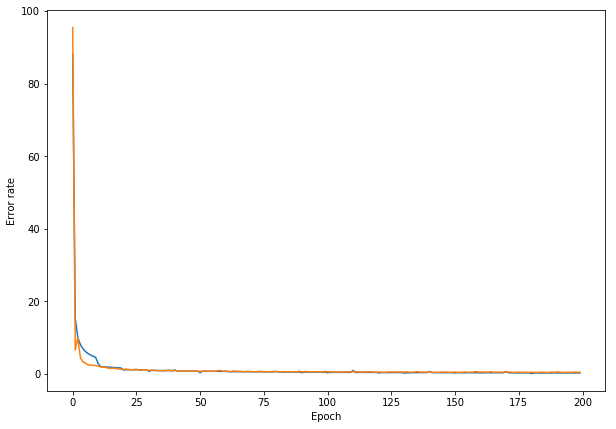

In [205]:
#绘制训练过程的误差曲线，校验集和测试集上的错误率。
plt.figure(figsize = (10, 7))
plt.plot(records) #record记载了每一个打印周期记录的训练和校验数据集上的准确度
plt.xlabel('Epoch')
plt.ylabel('Error rate')

In [206]:
# 在测试集上运行我们的加法机网络，并测试预测准确度

net.eval()
test_rights=[]
#对测试数据集进行循环
for tidx, test_data in enumerate(zip(test_loader1, test_loader2)):
    ((x5, y5), (x6, y6)) = test_data
    test_labels = y5 + y6
    test_outputs = net(Variable(x5), Variable(x6))
   
    test_rights.append(rightness(test_outputs.data, test_labels)) 
    test_right_ratio = float(np.sum([tup3 for tup3,tup4 in test_rights])) / float(np.sum([tup4 for tup3,tup4 in test_rights]))
    print('测试准确率：{:.2f}'.format(test_right_ratio))
    




测试准确率：0.94
测试准确率：0.95
测试准确率：0.95
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.97
测试准确率：0.97
测试准确率：0.97
测试准确率：0.97
测试准确率：0.97
测试准确率：0.97
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.96
测试准确率：0.96
测试准确率：0.95
测试准确率：0.95
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.95
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.95
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.95
测试准确率：0.96
测试准确率：0.96
测试准确率：0.96
